In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file
%matplotlib inline

# 1. BLS Salary Data

In [2]:
# Import salary information for occupations for all areas into a dataframe
salary_df = pd.read_excel('../data/raw/MSA_M2020_dl.xlsx', sheet_name = 'MSA_M2020_dl')

## Explore Salary Data

In [3]:
salary_df.head()

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,16.41,24.82,36.23,18990,23710,34130,51620,75370,NaN,NaN
1,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,36.37,51.68,73.88,36150,55620,75640,107500,153670,NaN,NaN
2,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,...,32.96,50.11,72.93,26350,49960,68550,104230,151700,NaN,NaN
3,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-2022,Sales Managers,...,52.41,68.01,#,54560,74680,109000,141460,#,NaN,NaN
4,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-2030,Public Relations and Fundraising Managers,...,36.24,41.23,83.81,59710,68180,75380,85760,174320,NaN,NaN


In [4]:
salary_df.shape

(140051, 31)

In [5]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140051 entries, 0 to 140050
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AREA          140051 non-null  int64  
 1   AREA_TITLE    140051 non-null  object 
 2   AREA_TYPE     140051 non-null  int64  
 3   PRIM_STATE    140051 non-null  object 
 4   NAICS         140051 non-null  int64  
 5   NAICS_TITLE   140051 non-null  object 
 6   I_GROUP       140051 non-null  object 
 7   OWN_CODE      140051 non-null  int64  
 8   OCC_CODE      140051 non-null  object 
 9   OCC_TITLE     140051 non-null  object 
 10  O_GROUP       140051 non-null  object 
 11  TOT_EMP       140051 non-null  object 
 12  EMP_PRSE      140051 non-null  object 
 13  JOBS_1000     140051 non-null  object 
 14  LOC_QUOTIENT  140051 non-null  object 
 15  PCT_TOTAL     0 non-null       float64
 16  H_MEAN        140051 non-null  object 
 17  A_MEAN        140051 non-null  object 
 18  MEAN

## Preliminary Cleaning

According to the dataset:

\*  = indicates that a wage estimate is not available	
\#  = indicates a wage equal to or greater than \\$100 per hour or $208,000 per year. 

These wages are very high and rare. They are outliers. So I'll replace the annual mean and hourly mean with these values.

In [6]:
# Occupations with "#" in place of their mean earnings using the lowest value available to us, the 10th percentile
salary_df['OCC_TITLE'][(salary_df['H_MEAN']=='#') | (salary_df['A_MEAN']=='#')].unique()

array(['Surgeons, Except Ophthalmologists', 'Anesthesiologists',
       'Physicians, All Other; and Ophthalmologists, Except Pediatric',
       'Obstetricians and Gynecologists',
       'General Internal Medicine Physicians',
       'Agents and Business Managers of Artists, Performers, and Athletes',
       'Dentists, General', 'Orthodontists', 'Psychiatrists',
       'Dentists, All Other Specialists', 'Family Medicine Physicians',
       'Oral and Maxillofacial Surgeons'], dtype=object)

In [7]:
# Replace '#' for annual and hourly mean
salary_df['H_MEAN'].str.replace('#','100')
salary_df['A_MEAN'].str.replace('#','208000')

print(salary_df[salary_df['H_MEAN']=='#'].value_counts())
print(salary_df[salary_df['A_MEAN']=='#'].value_counts())

Series([], dtype: int64)
Series([], dtype: int64)


### Drop columns and rows

I'm only interested in mean income values so the only income columns we keep are those two. Fields such as AREA, AREA_TYPE, NAICS, NAICS_TITLE, I_GROUP, OWN_CODE, TOT_EMP, EMP_PRSE, JOBS_1000, LOC_QUOTIENT, PCT_TOTAL, HOURLY and ANNUAL add no value to our analysis or help aid with cleaning further. I do keep O_GROUP because it will help filter rows that correspond to aggregate value for all occupations. After doing so we can get rid of that column as well and we remain with location, state, code, occupation, annual and hourly salaries.

In [8]:
# Unique values of O_group
salary_df['O_GROUP'].unique()

array(['total', 'major', 'detailed'], dtype=object)

In [9]:
# Aggregate values for all occuptions for a given location
salary_df[salary_df['O_GROUP']=='total'].head()

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,16.41,24.82,36.23,18990,23710,34130,51620,75370,NaN,NaN
281,10380,"Aguadilla-Isabela, PR",4,PR,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,9.37,14.13,22.35,16470,17600,19490,29400,46480,NaN,NaN
457,10420,"Akron, OH",4,OH,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,19.44,30.53,43.8,20500,27230,40440,63500,91100,NaN,NaN
953,10500,"Albany, GA",4,GA,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,15.77,26.32,38.33,17930,21810,32810,54740,79730,NaN,NaN
1186,10540,"Albany, OR",4,OR,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,19.13,28.68,41.45,25020,29560,39780,59650,86220,NaN,NaN


In [10]:
# Filter rows to get rid of aggregate values for all occupations
salary_df = salary_df.loc[salary_df['O_GROUP']!='total']
salary_df[salary_df['O_GROUP']=='total'].head()

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY


In [11]:
# Let's look at O_Group = 'major'
salary_df[salary_df['O_GROUP']=='major']

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
1,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,36.37,51.68,73.88,36150,55620,75640,107500,153670,NaN,NaN
18,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,13-0000,Business and Financial Operations Occupations,...,29.35,38.69,50.26,34280,45530,61040,80470,104530,NaN,NaN
34,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,15-0000,Computer and Mathematical Occupations,...,26.51,37.25,48.61,34250,43720,55130,77490,101120,NaN,NaN
41,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,17-0000,Architecture and Engineering Occupations,...,32.65,43.04,55.23,38740,50660,67900,89520,114880,NaN,NaN
51,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,19-0000,"Life, Physical, and Social Science Occupations",...,27.85,35.83,43.04,34870,43070,57940,74520,89520,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139927,79600,"Worcester, MA-CT",4,MA,0,Cross-industry,cross-industry,1235,45-0000,"Farming, Fishing, and Forestry Occupations",...,16.17,19.44,26.73,27700,29540,33640,40440,55600,NaN,NaN
139930,79600,"Worcester, MA-CT",4,MA,0,Cross-industry,cross-industry,1235,47-0000,Construction and Extraction Occupations,...,26.65,36.25,47.75,34280,42030,55420,75400,99320,NaN,NaN
139955,79600,"Worcester, MA-CT",4,MA,0,Cross-industry,cross-industry,1235,49-0000,"Installation, Maintenance, and Repair Occupations",...,24.95,32.07,40.87,32840,41550,51890,66710,85010,NaN,NaN
139980,79600,"Worcester, MA-CT",4,MA,0,Cross-industry,cross-industry,1235,51-0000,Production Occupations,...,19.3,25.13,31.87,27770,31530,40150,52270,66280,NaN,NaN


In [12]:
# Drop some columns right away since they won't be relevent to our problem and rename the columns
col_to_keep = ['OCC_CODE', 'OCC_TITLE','AREA_TITLE', 'PRIM_STATE', 'H_MEAN', 'A_MEAN']
salary_df = salary_df[col_to_keep]

# Rename columns
column_names = {'OCC_CODE':'code', 'OCC_TITLE':'occupation', 'PRIM_STATE':'state', 'AREA_TITLE':'location',
                'H_MEAN': 'hourly', 'A_MEAN':'annual'}
salary_df=salary_df.rename(columns=column_names)
salary_df.columns

Index(['code', 'occupation', 'location', 'state', 'hourly', 'annual'], dtype='object')

In [13]:
salary_df.head()

,code,occupation,location,state,hourly,annual
1,11-0000,Management Occupations,"Abilene, TX",TX,42.87,89160
2,11-1021,General and Operations Managers,"Abilene, TX",TX,40.38,83990
3,11-2022,Sales Managers,"Abilene, TX",TX,58.18,121020
4,11-2030,Public Relations and Fundraising Managers,"Abilene, TX",TX,45.93,95540
5,11-3010,Administrative Services and Facilities Managers,"Abilene, TX",TX,37.79,78600


### Duplicates

In [14]:
# Check for duplicates
salary_df.duplicated().any()

False

### Data types

In [15]:
# Remove dash from code before converting to numeric type
salary_df['code'] = salary_df['code'].str.replace('-','')
salary_df['code']

1         110000
2         111021
3         112022
4         112030
5         113010
           ...  
140046    537063
140047    537064
140048    537065
140049    537081
140050    537199
Name: code, Length: 139655, dtype: object

In [16]:
# List of fields to convert to numeric type
convert_to_float = ['code','hourly', 'annual']

# Convert to numeric type
salary_df[convert_to_float] = salary_df[convert_to_float].apply(pd.to_numeric, errors='coerce')
salary_df.dtypes

code            int64
occupation     object
location       object
state          object
hourly        float64
annual        float64
dtype: object

### Seperate location and state

In [17]:
# AREA_TITLE vs. state lables
area_split = salary_df['location'].str.split(', ', expand=True)
salary_df['location']=area_split[0]

In [18]:
# Let's also set our index to be the code column
salary_df.set_index('code', inplace=True)
salary_df.head()

,occupation,location,state,hourly,annual
code,,,,,
110000,Management Occupations,Abilene,TX,42.87,89160.0
111021,General and Operations Managers,Abilene,TX,40.38,83990.0
112022,Sales Managers,Abilene,TX,58.18,121020.0
112030,Public Relations and Fundraising Managers,Abilene,TX,45.93,95540.0
113010,Administrative Services and Facilities Managers,Abilene,TX,37.79,78600.0


## Categorical Variables

In [19]:
# Select categorical variable types
salary_df.select_dtypes('object').head()

,occupation,location,state
code,,,
110000,Management Occupations,Abilene,TX
111021,General and Operations Managers,Abilene,TX
112022,Sales Managers,Abilene,TX
112030,Public Relations and Fundraising Managers,Abilene,TX
113010,Administrative Services and Facilities Managers,Abilene,TX


### Area and state

In [20]:
# Unique states
print(salary_df['state'].nunique()) 
print(salary_df['state'].unique()) 
salary_df['state'].value_counts().head() 

52
['TX' 'PR' 'OH' 'GA' 'OR' 'NY' 'NM' 'LA' 'PA' 'IA' 'AK' 'MI' 'AL' 'WI'
 'NC' 'NJ' 'CA' 'MD' 'WV' 'WA' 'MT' 'ND' 'VA' 'IL' 'IN' 'ID' 'CO' 'KY'
 'FL' 'MO' 'NV' 'WY' 'SC' 'TN' 'DE' 'MN' 'OK' 'AR' 'AZ' 'NE' 'MS' 'HI'
 'KS' 'UT' 'SD' 'DC' 'ME' 'MA' 'CT' 'VT' 'NH' 'RI']


CA    10687
TX     9295
FL     8296
PA     6388
NC     5405
Name: state, dtype: int64

In [21]:
# How many unique AREA_TITLES?
print(salary_df['location'].nunique())
salary_df['location'].value_counts().head()

379


Springfield     1467
Columbus        1166
Jackson          960
Rochester        873
Jacksonville     767
Name: location, dtype: int64

The most common values appear to be for metropolitan areas which makes sense since they are highly concentrated and more jobs are available in these areas. 

There are 52 states (inclduing DC PR). California, Texas and Florida have the most jobs, consistent with being the most populated states. 

### Occupations

In [22]:
# Number of unique occupation titles
print(salary_df['occupation'].nunique())
salary_df['occupation'].value_counts().head()

807


Management Occupations                                                 396
Sales and Related Occupations                                          396
Bookkeeping, Accounting, and Auditing Clerks                           396
First-Line Supervisors of Office and Administrative Support Workers    396
Office and Administrative Support Occupations                          396
Name: occupation, dtype: int64

## Numerical Variables

### Missing Values

In [23]:
# Summary statistics for hourly and annual income
salary_df.describe().T

,count,mean,std,min,25%,50%,75%,max
hourly,130371.0,27.180272,15.478112,8.32,17.07,22.93,32.62,151.84
annual,136807.0,57102.424291,32075.371957,17300.00,35830.00,48560.00,68970.00,315830.00


In [24]:
# Count and percent missing values
missing_counts = pd.concat([salary_df.isnull().sum(), round(100 * salary_df.isnull().mean())], axis=1)
missing_counts.columns=['count', '%']
missing_counts.sort_values(by='count', ascending=False)

,count,%
hourly,9284,7.0
annual,2848,2.0
occupation,0,0.0
location,0,0.0
state,0,0.0


There are no missing values for the categorical values occupation, location and state.

Annual salary is only missing 2 percent of its values, compared to 7 percent for hourly income.

### Target feature

The annual income was calcalted by multiplying the hourly income by the full-time hours of 2080. There were some cases where hourly was not available but annual income was reported. Artists, teachers, actors and other fall in that category. Since annual income is missing fewer values, I can drop the hourly column then delete rows that are missing the annual income.

In [25]:
# Drop the hourly column
salary_df = salary_df.drop(columns=['hourly'])
salary_df.columns

Index(['occupation', 'location', 'state', 'annual'], dtype='object')

In [26]:
# Drop rows with null values
salary_df = salary_df.dropna()
salary_df.isna().sum()

occupation    0
location      0
state         0
annual        0
dtype: int64

In [27]:
salary_df.head()

,occupation,location,state,annual
code,,,,
110000,Management Occupations,Abilene,TX,89160.0
111021,General and Operations Managers,Abilene,TX,83990.0
112022,Sales Managers,Abilene,TX,121020.0
112030,Public Relations and Fundraising Managers,Abilene,TX,95540.0
113010,Administrative Services and Facilities Managers,Abilene,TX,78600.0


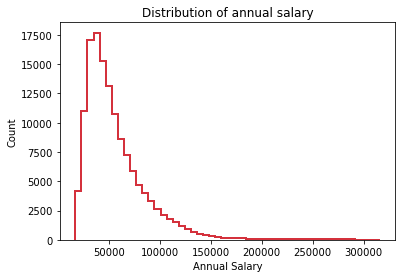

In [28]:
# Annual wage distriution
salary_df['annual'].hist(bins=50, color='#d4313c', histtype='step', linewidth = 2)
plt.xlabel('Annual Salary')
plt.ylabel('Count')
plt.title('Distribution of annual salary')
plt.grid(False);

In [29]:
# Salary dataframe summary statistics for annual and hourly wage
salary_df.describe().T

,count,mean,std,min,25%,50%,75%,max
annual,136807.0,57102.424291,32075.371957,17300.0,35830.0,48560.0,68970.0,315830.0


Median annual income is 48,560 dollars. Maximum values is 315,830 dollars but the high values are relatively few.

In [30]:
# Save cleaned salary data
salary_df.to_csv('../data/interim/salary_clean.csv')

# 2. O'NET Skills Data

In [31]:
#Read skills information for occupations into a dataframe
skills_df = pd.read_excel('../data/raw/Skills.xlsx')

## Explore O'NET Data

In [32]:
skills_df.head()

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source
0,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,07/2014,Analyst
1,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,LV,Level,4.75,8.0,0.16,4.43,5.07,N,N,07/2014,Analyst
2,11-1011.00,Chief Executives,2.A.1.b,Active Listening,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,07/2014,Analyst
3,11-1011.00,Chief Executives,2.A.1.b,Active Listening,LV,Level,4.88,8.0,0.23,4.43,5.32,N,N,07/2014,Analyst
4,11-1011.00,Chief Executives,2.A.1.c,Writing,IM,Importance,4.00,8.0,0.00,4.00,4.00,N,NaN,07/2014,Analyst


In [33]:
skills_df.columns

Index(['O*NET-SOC Code', 'Title', 'Element ID', 'Element Name', 'Scale ID',
       'Scale Name', 'Data Value', 'N', 'Standard Error', 'Lower CI Bound',
       'Upper CI Bound', 'Recommend Suppress', 'Not Relevant', 'Date',
       'Domain Source'],
      dtype='object')

In [34]:
skills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61110 entries, 0 to 61109
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   O*NET-SOC Code      61110 non-null  object 
 1   Title               61110 non-null  object 
 2   Element ID          61110 non-null  object 
 3   Element Name        61110 non-null  object 
 4   Scale ID            61110 non-null  object 
 5   Scale Name          61110 non-null  object 
 6   Data Value          61110 non-null  float64
 7   N                   57400 non-null  float64
 8   Standard Error      57400 non-null  float64
 9   Lower CI Bound      57400 non-null  float64
 10  Upper CI Bound      57400 non-null  float64
 11  Recommend Suppress  61110 non-null  object 
 12  Not Relevant        30555 non-null  object 
 13  Date                61110 non-null  object 
 14  Domain Source       61110 non-null  object 
dtypes: float64(5), object(10)
memory usage: 7.0+ MB


### Column definitions

I'll be using the O\*Net code to join with the salary dataframe from BLS data above. According to their website: 

   "The O\*NET Database is in compliance with the current federal mandate to follow the Standard Occupational Classification (SOC). The O\*NET Database uses the basic 6-digit numerical coding structure of the SOC as its framework, adding a 2-digit extension (sequentially numbered beginning with ".01") to differentiate unique O\*NET occupations within the SOC system."

The level, importance and frequency scales each have a different range of possible scores. Ratings on Level were collected on a 0-7 scale, ratings on Importance were collected on a 1-5 scale, and ratings on Frequency were collected on a 1-4 scale. To make reports generated by O*NET OnLine more intuitively understandable to users, descriptor average ratings were standardized to a scale ranging from 0 to 100. The equation for conversion of original ratings to standardized scores is:

S = ( (O - L) / (H - L) ) * 100

where S is the standardized score, O is the original rating score on one of the three scales, L is the lowest possible score on the rating scale used, and H is the highest possible score on the rating scale used. For example, an original Importance rating score of 3 is converted to a standardized score of 50 (50 = [ [3 - 1] / [5 - 1] ] * 100). For another example, an original Level rating score of 5 is converted to a standardized score of 71 (71 = [ [5 - 0] / [7 - 0] ] * 100).

Element ID and Scale ID don't give us any more information than the Element Name and Scale Name columns so there is no need to keep them.

We can also drop the the rating level statistics columns: N, Standard Error, Upper and Lower CI Bound, Recommend Suppress and Not Relevant.

## Initial Cleaning

In [35]:
# Construct skills datafram from relevent columns, rename columns and set the O*Net code as the index
skills_df = skills_df[['O*NET-SOC Code', 'Title', 'Element Name', 'Scale Name', 'Data Value']]
skills_df = skills_df.rename(columns={'O*NET-SOC Code':'code', 'Title':'occupation', 'Element Name':'skill', 'Scale Name':
                                     'scale_name', 'Data Value':'scale_value'})
skills_df.head()

,code,occupation,skill,scale_name,scale_value
0,11-1011.00,Chief Executives,Reading Comprehension,Importance,4.12
1,11-1011.00,Chief Executives,Reading Comprehension,Level,4.75
2,11-1011.00,Chief Executives,Active Listening,Importance,4.12
3,11-1011.00,Chief Executives,Active Listening,Level,4.88
4,11-1011.00,Chief Executives,Writing,Importance,4.00


In [36]:
# Remove '-' and '.' from the code column
skills_df['code'] = skills_df['code'].str.replace('-','')
skills_df['code'] = skills_df['code'].str.split('.').str[0]

# Convert code to numeric type
skills_df['code'] = skills_df['code'].apply(pd.to_numeric)

# Set code as index
skills_df = skills_df.set_index('code')
skills_df.head()

,occupation,skill,scale_name,scale_value
code,,,,
111011,Chief Executives,Reading Comprehension,Importance,4.12
111011,Chief Executives,Reading Comprehension,Level,4.75
111011,Chief Executives,Active Listening,Importance,4.12
111011,Chief Executives,Active Listening,Level,4.88
111011,Chief Executives,Writing,Importance,4.00


In [37]:
skills_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61110 entries, 111011 to 537121
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   occupation   61110 non-null  object 
 1   skill        61110 non-null  object 
 2   scale_name   61110 non-null  object 
 3   scale_value  61110 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


### Duplicates

In [38]:
# Find duplicates
skills_df.duplicated().any()

False

We don't have any missing values in our columns of interest and they are all of correct data type.

In [39]:
skills_df.shape

(61110, 4)

There must have been no duplicates so we get the same number of rows back. 

### Occupation

In [40]:
skills_df['occupation'].nunique()

873

### Scales

In [41]:
# Unique scale_name values
skills_df['scale_name'].unique()

array(['Importance', 'Level'], dtype=object)

In [42]:
# For now just get a df with only importance scale values and drop scale_name column and rename value column
skills_df = skills_df.loc[skills_df['scale_name'] == 'Importance']
skills_df.drop(columns='scale_name', inplace=True)
skills_df.rename(columns={'scale_value':'importance'}, inplace=True)
skills_df.head()

,occupation,skill,importance
code,,,
111011,Chief Executives,Reading Comprehension,4.12
111011,Chief Executives,Active Listening,4.12
111011,Chief Executives,Writing,4.00
111011,Chief Executives,Speaking,4.38
111011,Chief Executives,Mathematics,3.25


### Skills

In [43]:
print(skills_df.skill.nunique())
print(skills_df.skill.unique())

35
['Reading Comprehension' 'Active Listening' 'Writing' 'Speaking'
 'Mathematics' 'Science' 'Critical Thinking' 'Active Learning'
 'Learning Strategies' 'Monitoring' 'Social Perceptiveness' 'Coordination'
 'Persuasion' 'Negotiation' 'Instructing' 'Service Orientation'
 'Complex Problem Solving' 'Operations Analysis' 'Technology Design'
 'Equipment Selection' 'Installation' 'Programming'
 'Operations Monitoring' 'Operation and Control' 'Equipment Maintenance'
 'Troubleshooting' 'Repairing' 'Quality Control Analysis'
 'Judgment and Decision Making' 'Systems Analysis' 'Systems Evaluation'
 'Time Management' 'Management of Financial Resources'
 'Management of Material Resources' 'Management of Personnel Resources']


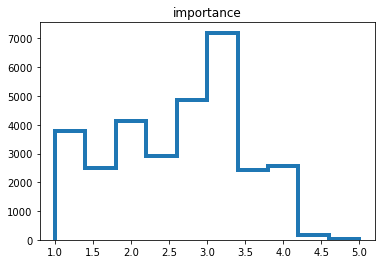

In [44]:
# Distribution of skill values
skills_df.hist(histtype='step', linewidth=4)
plt.grid(False);

In [45]:
# Save clean skills data
skills_df.to_csv('../data/interim/skills_clean.csv')

# 3. Join Salary and Skills Dataframes

In [46]:
# Inner join skills and salary dataframes using using index
skill_salary = skills_df.join(salary_df, lsuffix='_onet', rsuffix='_bls', how='inner')
skill_salary.head()

,occupation_onet,skill,importance,occupation_bls,location,state,annual
code,,,,,,,
111011,Chief Executives,Reading Comprehension,4.12,Chief Executives,Aguadilla-Isabela,PR,92200.0
111011,Chief Executives,Reading Comprehension,4.12,Chief Executives,Akron,OH,204420.0
111011,Chief Executives,Reading Comprehension,4.12,Chief Executives,Albany,GA,121260.0
111011,Chief Executives,Reading Comprehension,4.12,Chief Executives,Albany-Schenectady-Troy,NY,155870.0
111011,Chief Executives,Reading Comprehension,4.12,Chief Executives,Allentown-Bethlehem-Easton,PA,215910.0


## Explore joined datasets

In [47]:
skill_salary.shape

(4771830, 7)

In [48]:
# Any null values?
skill_salary.isna().sum()

occupation_onet    0
skill              0
importance         0
occupation_bls     0
location           0
state              0
annual             0
dtype: int64

In [49]:
# Instances where joined occupations (based on SOC code) have different titles from each source
map_occupation = skill_salary[['occupation_onet','occupation_bls']][skill_salary['occupation_bls'] != skill_salary['occupation_onet']].value_counts().reset_index()
map_occupation

,occupation_onet,occupation_bls,0
0,Baristas,Fast Food and Counter Workers,13860
1,Recycling and Reclamation Workers,"Laborers and Freight, Stock, and Material Move...",13790
2,Solar Energy Installation Managers,First-Line Supervisors of Construction Trades ...,13755
3,Investment Fund Managers,Financial Managers,13720
4,Treasurers and Controllers,Financial Managers,13720
...,...,...,...
96,Art Therapists,"Therapists, All Other",2030
97,Biofuels Processing Technicians,"Plant and System Operators, All Other",1855
98,Environmental Economists,Economists,1820
99,Robotics Technicians,Electro-Mechanical and Mechatronics Technologi...,1680


### Clean skill_salary dataframe

In [50]:
# Drop occupation_bls and keep the onet (more detailed) titles
skill_salary = skill_salary[['occupation_onet', 'skill', 'importance', 'location', 'state', 'annual']]
skill_salary.head()

,occupation_onet,skill,importance,location,state,annual
code,,,,,,
111011,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
111011,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
111011,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
111011,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
111011,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


In [51]:
# Rename occupation_onet 
skill_salary = skill_salary.rename(columns={'occupation_onet':'occupation'})
skill_salary.head()

,occupation,skill,importance,location,state,annual
code,,,,,,
111011,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
111011,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
111011,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
111011,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
111011,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


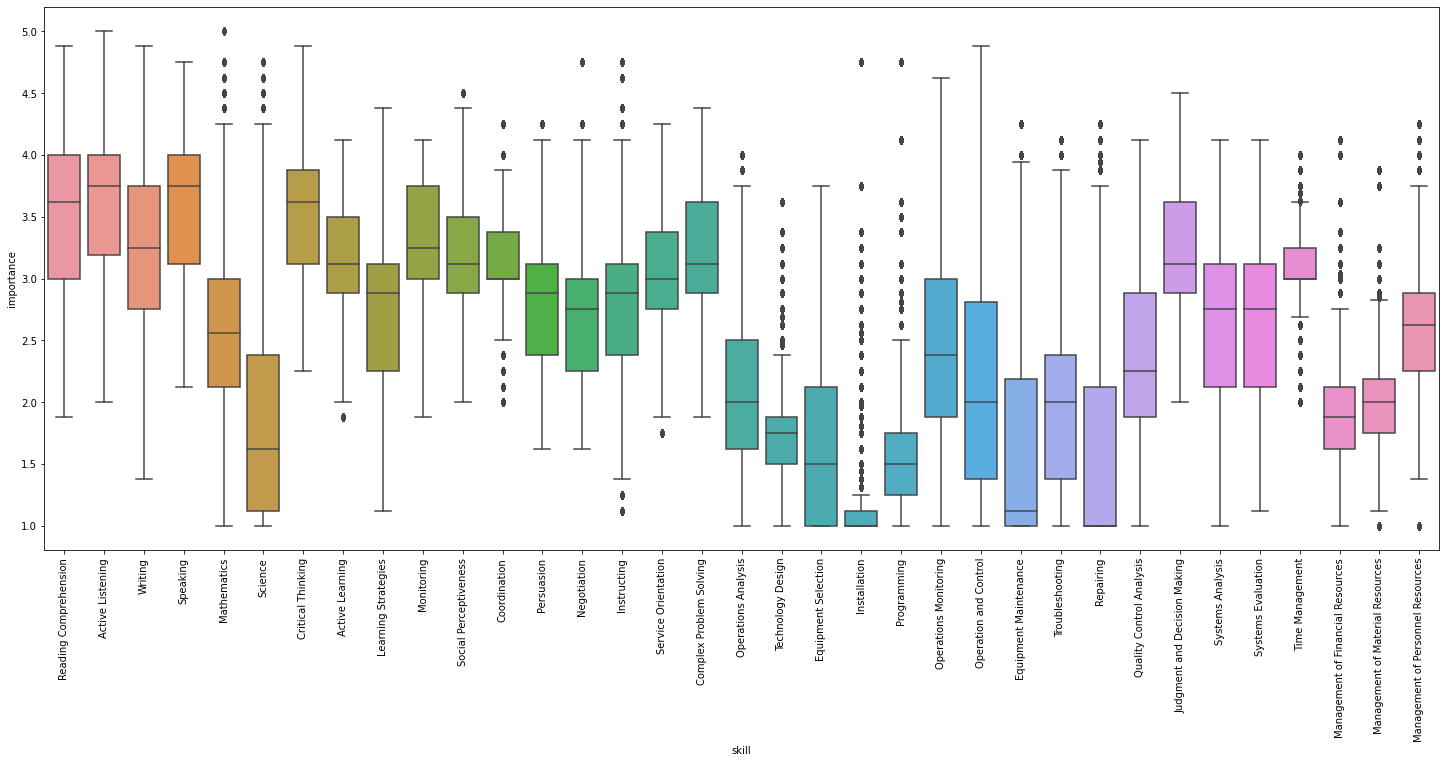

In [52]:
# Plot the distrubution of values for each skill using boxplots
plt.subplots(figsize=(25,10))
sns.boxplot(x='skill', y='importance', data=skill_salary)
plt.xticks(rotation=90);

## Report and Summary

In [55]:
# Run a profile roport on final dataframe
profile = skill_salary.profile_report(html={'style': {'full_width': True}})
profile.to_file('../reports/skill_salary_profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

3 is the most common value for importance followed by 1. Whole values such as 3, 1, 2, and 4 are among the top 10 most frequent values which makes sense, given the tendacy to use whole numbers. The highest value, 5 is rare.

California, Texas and Florida have the highest number of jobs. These have more centers with high population density.

The annual salary skewed to the right indicating very few occupations earn above $150,000.

In [56]:
skill_salary.to_csv('../data/interim/skill_salary_clean.csv')